<a href="https://colab.research.google.com/drive/1wox8ShtJ_bV7CpFO4fwt98ZMVbHu65V-?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Read the data
data = pd.read_csv('aquifer_time_series (1).csv')
data.head(12)

,date,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m
0,14/03/2006,NaN,-22.18,NaN,NaN,NaN
1,15/03/2006,NaN,-22.14,NaN,NaN,NaN
2,16/03/2006,NaN,-22.04,NaN,NaN,NaN
3,17/03/2006,NaN,-22.04,NaN,NaN,NaN
4,18/03/2006,NaN,-22.04,NaN,NaN,NaN
5,19/03/2006,NaN,-21.95,NaN,NaN,NaN
6,20/03/2006,NaN,-21.99,NaN,NaN,NaN
7,21/03/2006,NaN,-21.89,NaN,NaN,NaN
8,22/03/2006,NaN,-21.82,NaN,NaN,NaN
9,23/03/2006,NaN,-21.89,NaN,NaN,NaN


In [ ]:
df= data

## Pre-processing the Data

### Handling missing data

In [ ]:
df.isna().sum()

,0
date,0
rainfall_mm,1024
depth_to_groundwater_m,39
temperature_C,1024
drainage_m3,198
river_hydrometry_m,1024


In [ ]:
rain= df[df['rainfall_mm'].isna()]
print(rain)

            date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0     14/03/2006          NaN                  -22.18            NaN   
1     15/03/2006          NaN                  -22.14            NaN   
2     16/03/2006          NaN                  -22.04            NaN   
3     17/03/2006          NaN                  -22.04            NaN   
4     18/03/2006          NaN                  -22.04            NaN   
...          ...          ...                     ...            ...   
1019  27/12/2008          NaN                  -31.50            NaN   
1020  28/12/2008          NaN                  -31.41            NaN   
1021  29/12/2008          NaN                  -31.37            NaN   
1022  30/12/2008          NaN                  -31.39            NaN   
1023  31/12/2008          NaN                  -31.33            NaN   

      drainage_m3  river_hydrometry_m  
0             NaN                 NaN  
1             NaN                 NaN  
2             N

Replacing 'na' values with the mean precipitation for 2009 adjusted for each year in accordance to NOAA (2024) data.

In [ ]:
# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Filter data for dates ending in 2009
df_2009 = df[df['date'].dt.year == 2009]

# Calculate the mean rainfall_mm for 2009
mean_rain_2009 = df_2009['rainfall_mm'].mean()

# Calculate the mean rainfall_mm for years 2006-2008
adj_rain_2008 = mean_rain_2009 + 1.99
adj_rain_2007 = mean_rain_2009 + 1.50
adj_rain_2006 = mean_rain_2009 + 1.68

# Replace NaN values in 'rainfall_mm' for 2006 with adj_rain_2006
df.loc[(df['date'].dt.year == 2006) & (df['rainfall_mm'].isna()), 'rainfall_mm'] = adj_rain_2006
# Replace NaN values in 'rainfall_mm' for 2007 with adj_rain_2007
df.loc[(df['date'].dt.year == 2007) & (df['rainfall_mm'].isna()), 'rainfall_mm'] = adj_rain_2007
# Replace NaN values in 'rainfall_mm' for 2008 with adj_rain_2008
df.loc[(df['date'].dt.year == 2008) & (df['rainfall_mm'].isna()), 'rainfall_mm'] = adj_rain_2008
print(df)
print(mean_rain_2009)

           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18            NaN   
1    2006-03-15     2.396438                  -22.14            NaN   
2    2006-03-16     2.396438                  -22.04            NaN   
3    2006-03-17     2.396438                  -22.04            NaN   
4    2006-03-18     2.396438                  -22.04            NaN   
...         ...          ...                     ...            ...   
5218 2020-06-26     0.000000                  -25.07           25.7   
5219 2020-06-27     0.000000                  -25.11           26.2   
5220 2020-06-28     0.000000                  -25.19           26.9   
5221 2020-06-29     0.000000                  -25.18           26.9   
5222 2020-06-30     0.000000                  -25.25           27.3   

      drainage_m3  river_hydrometry_m  
0             NaN                 NaN  
1             NaN                 NaN  
2             NaN          

<ipython-input-190-f016a1188de9>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [ ]:
temp= df[df['temperature_C'].isna()]
print(temp)

           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18            NaN   
1    2006-03-15     2.396438                  -22.14            NaN   
2    2006-03-16     2.396438                  -22.04            NaN   
3    2006-03-17     2.396438                  -22.04            NaN   
4    2006-03-18     2.396438                  -22.04            NaN   
...         ...          ...                     ...            ...   
1019 2008-12-27     2.706438                  -31.50            NaN   
1020 2008-12-28     2.706438                  -31.41            NaN   
1021 2008-12-29     2.706438                  -31.37            NaN   
1022 2008-12-30     2.706438                  -31.39            NaN   
1023 2008-12-31     2.706438                  -31.33            NaN   

      drainage_m3  river_hydrometry_m  
0             NaN                 NaN  
1             NaN                 NaN  
2             NaN          

Replacing 'na' values with the mean temperature for 2009 adjusted for each year in accordance to NOAA (2024) data.

In [ ]:
# Calculate the mean temperature_C for 2009
mean_temp_2009 = df_2009['temperature_C'].mean()

# Calculate the mean temperature_C for years 2006-2008
adj_temp_2008 = mean_temp_2009 - 0.13
adj_temp_2007 = mean_temp_2009 - 0.03
adj_temp_2006 = mean_temp_2009 - 0.02

# Replace NaN values in 'temperature_C' for 2006 with adj_temp_2006
df.loc[(df['date'].dt.year == 2006) & (df['temperature_C'].isna()), 'temperature_C'] = adj_temp_2006
# Replace NaN values in 'temperature_C' for 2007 with adj_temp_2007
df.loc[(df['date'].dt.year == 2007) & (df['temperature_C'].isna()), 'temperature_C'] = adj_temp_2007
# Replace NaN values in 'temperature_C' for 2008 with adj_temp_2008
df.loc[(df['date'].dt.year == 2008) & (df['temperature_C'].isna()), 'temperature_C'] = adj_temp_2008

print(df)


           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18      14.778082   
1    2006-03-15     2.396438                  -22.14      14.778082   
2    2006-03-16     2.396438                  -22.04      14.778082   
3    2006-03-17     2.396438                  -22.04      14.778082   
4    2006-03-18     2.396438                  -22.04      14.778082   
...         ...          ...                     ...            ...   
5218 2020-06-26     0.000000                  -25.07      25.700000   
5219 2020-06-27     0.000000                  -25.11      26.200000   
5220 2020-06-28     0.000000                  -25.19      26.900000   
5221 2020-06-29     0.000000                  -25.18      26.900000   
5222 2020-06-30     0.000000                  -25.25      27.300000   

      drainage_m3  river_hydrometry_m  
0             NaN                 NaN  
1             NaN                 NaN  
2             NaN          

Replacing 'na' values for groundwater depth and drainage with the mean precipitation for the corresponding year

In [ ]:
for year in df['date'].dt.year.unique():
    mean_depth = df[(df['date'].dt.year == year) & (~df['depth_to_groundwater_m'].isna())]['depth_to_groundwater_m'].mean()
    # Replace NaN values in 'depth_to_groundwater_m' for the current year with the calculated mean
    df.loc[(df['date'].dt.year == year) & (df['depth_to_groundwater_m'].isna()), 'depth_to_groundwater_m'] = mean_depth

    mean_drain = df[(df['date'].dt.year == year) & (~df['drainage_m3'].isna())]['drainage_m3'].mean()
    # Replace NaN values in 'drainage_m3' for the current year with the calculated mean
    df.loc[(df['date'].dt.year == year) & (df['drainage_m3'].isna()), 'drainage_m3'] = mean_drain

print(df)

           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18      14.778082   
1    2006-03-15     2.396438                  -22.14      14.778082   
2    2006-03-16     2.396438                  -22.04      14.778082   
3    2006-03-17     2.396438                  -22.04      14.778082   
4    2006-03-18     2.396438                  -22.04      14.778082   
...         ...          ...                     ...            ...   
5218 2020-06-26     0.000000                  -25.07      25.700000   
5219 2020-06-27     0.000000                  -25.11      26.200000   
5220 2020-06-28     0.000000                  -25.19      26.900000   
5221 2020-06-29     0.000000                  -25.18      26.900000   
5222 2020-06-30     0.000000                  -25.25      27.300000   

      drainage_m3  river_hydrometry_m  
0      -33655.914                 NaN  
1      -33655.914                 NaN  
2      -33655.914          

In [ ]:
river= df[df['river_hydrometry_m'].isna()]
print(river)

           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18      14.778082   
1    2006-03-15     2.396438                  -22.14      14.778082   
2    2006-03-16     2.396438                  -22.04      14.778082   
3    2006-03-17     2.396438                  -22.04      14.778082   
4    2006-03-18     2.396438                  -22.04      14.778082   
...         ...          ...                     ...            ...   
1019 2008-12-27     2.706438                  -31.50      14.668082   
1020 2008-12-28     2.706438                  -31.41      14.668082   
1021 2008-12-29     2.706438                  -31.37      14.668082   
1022 2008-12-30     2.706438                  -31.39      14.668082   
1023 2008-12-31     2.706438                  -31.33      14.668082   

      drainage_m3  river_hydrometry_m  
0      -33655.914                 NaN  
1      -33655.914                 NaN  
2      -33655.914          

Replacing 'na' values with the mean hydrometry values for for the years which display the most similar precipitaion values to NOAA (2024) data. This means that the missing data between the years 2006-2008 for hydrometry are replaced with estimates, that reflect the relationship between precipitation and river hydrometry.

In [ ]:
df_2011 = df[df['date'].dt.year == 2011]
df_2016 = df[df['date'].dt.year == 2016]
df_2020 = df[df['date'].dt.year == 2020]
# Calculate the river_hydrometry_m for 2009
mean_river_2011 = df_2011['river_hydrometry_m'].mean()
mean_river_2016 = df_2016['river_hydrometry_m'].mean()
mean_river_2020 = df_2020['river_hydrometry_m'].mean()

# Calculate the mean river_hydrometry_m for years 2006-2008
adj_river_2008 = mean_river_2011
adj_river_2007 = mean_river_2016
adj_river_2006 = mean_river_2020

# Replace NaN values in 'river_hydrometry_m' for 2006 with adj_river_2006
df.loc[(df['date'].dt.year == 2006) & (df['river_hydrometry_m'].isna()), 'river_hydrometry_m'] = adj_river_2006
# Replace NaN values in 'river_hydrometry_m' for 2007 with adj_river_2007
df.loc[(df['date'].dt.year == 2007) & (df['river_hydrometry_m'].isna()), 'river_hydrometry_m'] = adj_river_2007
# Replace NaN values in 'river_hydrometry_m' for 2008 with adj_river_2008
df.loc[(df['date'].dt.year == 2008) & (df['river_hydrometry_m'].isna()), 'river_hydrometry_m'] = adj_river_2008

print(df)

           date  rainfall_mm  depth_to_groundwater_m  temperature_C  \
0    2006-03-14     2.396438                  -22.18      14.778082   
1    2006-03-15     2.396438                  -22.14      14.778082   
2    2006-03-16     2.396438                  -22.04      14.778082   
3    2006-03-17     2.396438                  -22.04      14.778082   
4    2006-03-18     2.396438                  -22.04      14.778082   
...         ...          ...                     ...            ...   
5218 2020-06-26     0.000000                  -25.07      25.700000   
5219 2020-06-27     0.000000                  -25.11      26.200000   
5220 2020-06-28     0.000000                  -25.19      26.900000   
5221 2020-06-29     0.000000                  -25.18      26.900000   
5222 2020-06-30     0.000000                  -25.25      27.300000   

      drainage_m3  river_hydrometry_m  
0      -33655.914            2.536813  
1      -33655.914            2.536813  
2      -33655.914          

In [ ]:
df.isna().sum()

,0
date,0
rainfall_mm,0
depth_to_groundwater_m,0
temperature_C,0
drainage_m3,0
river_hydrometry_m,0


### Formating the Data

In [ ]:
def format_data(df):

  # Extract month and year
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year

  # Drop the original 'date' column
  df = df.drop('date', axis=1)

  #Grouping data by month and year

  # Group data by year and month, then calculate the mean for each column
  df = df.groupby(['year', 'month']).mean().reset_index()

  for col in ['rainfall_mm', 'temperature_C', 'river_hydrometry_m', 'drainage_m3']:
          for lag in range(1, 13):
              df[f'{col}_lag_{lag}'] = df[col].shift(lag)

  ds = df.dropna().reset_index(drop=True)
  return ds

ds = format_data(df)
ds


,year,month,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m,rainfall_mm_lag_1,rainfall_mm_lag_2,rainfall_mm_lag_3,...,drainage_m3_lag_3,drainage_m3_lag_4,drainage_m3_lag_5,drainage_m3_lag_6,drainage_m3_lag_7,drainage_m3_lag_8,drainage_m3_lag_9,drainage_m3_lag_10,drainage_m3_lag_11,drainage_m3_lag_12
0,2007,3,2.216438,-26.290645,14.768082,-28470.137806,2.789344,2.216438,2.216438,2.396438,...,-33476.989935,-34178.832000,-33863.197935,-33103.690800,-33655.914000,-33655.914000,-33655.914000,-33655.914000,-33655.914000,-33655.914000
1,2007,4,2.216438,-26.149333,14.768082,-30394.483200,2.789344,2.216438,2.216438,2.216438,...,-35619.654194,-33476.989935,-34178.832000,-33863.197935,-33103.690800,-33655.914000,-33655.914000,-33655.914000,-33655.914000,-33655.914000
2,2007,5,2.216438,-26.015103,14.768082,-28765.402839,2.789344,2.216438,2.216438,2.216438,...,-32426.537143,-35619.654194,-33476.989935,-34178.832000,-33863.197935,-33103.690800,-33655.914000,-33655.914000,-33655.914000,-33655.914000
3,2007,6,2.216438,-26.538333,14.768082,-33333.868800,2.789344,2.216438,2.216438,2.216438,...,-28470.137806,-32426.537143,-35619.654194,-33476.989935,-34178.832000,-33863.197935,-33103.690800,-33655.914000,-33655.914000,-33655.914000
4,2007,7,2.216438,-27.920000,14.768082,-42091.655226,2.789344,2.216438,2.216438,2.216438,...,-30394.483200,-28470.137806,-32426.537143,-35619.654194,-33476.989935,-34178.832000,-33863.197935,-33103.690800,-33655.914000,-33655.914000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2020,2,0.641379,-25.261724,8.989655,-28354.096552,2.420690,0.496774,1.838710,4.946667,...,-26862.825600,-26346.453677,-27027.417600,-18158.353548,-19681.836387,-23556.009600,-22416.312774,-24255.676800,-25842.546581,-26068.916571
156,2020,3,2.264516,-24.970812,9.758065,-26783.275355,2.722581,0.641379,0.496774,1.838710,...,-23976.390194,-26862.825600,-26346.453677,-27027.417600,-18158.353548,-19681.836387,-23556.009600,-22416.312774,-24255.676800,-25842.546581
157,2020,4,1.386667,-24.814835,14.016667,-24634.598400,2.500000,2.264516,0.641379,0.496774,...,-27106.272000,-23976.390194,-26862.825600,-26346.453677,-27027.417600,-18158.353548,-19681.836387,-23556.009600,-22416.312774,-24255.676800
158,2020,5,1.470968,-24.716774,18.754839,-24104.067097,2.470968,1.386667,2.264516,0.641379,...,-28354.096552,-27106.272000,-23976.390194,-26862.825600,-26346.453677,-27027.417600,-18158.353548,-19681.836387,-23556.009600,-22416.312774


The final clean dataset is referred to as ds.

### Pipeline

In [ ]:
def make_pipeline(ds):

  # Define features for the regression
  numeric_features = [col for col in data.columns if '_lag_' in col]
  categorical_features = ['month']

  # Create transformers
  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
      ])
  # Use OneHotEncoder for categorical features (aka)
  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(sparse_output=False))
  ])
  # Combine transformers using ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features)
      ])

  # Create the pipeline
  pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('regressor', RandomForestRegressor())
  ])


  return pipeline



## Modelling the Data

### Model's main code

In [ ]:
def main(ds, pipeline):

  # Prepare data for the pipeline
  X = ds.drop('depth_to_groundwater_m', axis=1) # Features
  y = ds['depth_to_groundwater_m'] # Target variable

  #Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Initialize and train the RandomForestRegressor model
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred = model.predict(X_test)

  # Calculate the input and output sizes
  input_size = X.shape[1]
  output_size = 1

  return model, y_pred, input_size, output_size, X_train, X_test, y_train, y_test
model_pred = model, y_pred, input_size, output_size

print(model_pred)

(RandomForestRegressor(random_state=42), array([-23.45521688, -23.99507787, -26.18937386, -27.61915181,
       -22.31359077, -29.08759023, -22.17481795, -24.60665964,
       -22.39483655, -25.94998038, -30.32851662, -22.78189004,
       -30.14558541, -29.7444936 , -27.83418577, -29.55888032,
       -26.06682211, -24.87638577, -21.84262871, -30.35542582,
       -23.59380292, -30.44019991, -29.91510932, -29.58803338,
       -29.40226952, -25.74853771, -21.8078007 , -28.1935266 ,
       -25.359073  , -23.00025025, -24.99175805, -25.32155454,
       -27.79774387, -24.66147499, -27.14286709, -24.53873805,
       -26.68631218, -26.6164765 , -29.08898453, -21.91477827,
       -27.62823423, -25.76615198, -23.62768339, -22.11750675,
       -24.57493938, -26.87084402, -25.26606702, -29.43032269]), 54, 1)


In [ ]:
def cross_validation(model, X, y, groups, n_splits=5):

    gkf= GroupKFold(n_splits=n_splits)
    n_pipeline = make_pipeline(ds)
    cv_scores = cross_val_score(pipeline, X, y, cv=gkf, groups=groups,
                                scoring='neg_mean_squared_error')

    return  cv_scores


# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

Cross-validation scores: [-19.35645824  -4.53503001  -7.34598884 -12.34275382 -13.33234955]
Mean cross-validation score: -11.382516094423348
Standard deviation of cross-validation scores: 5.1281434890161615


### Evaluating my model

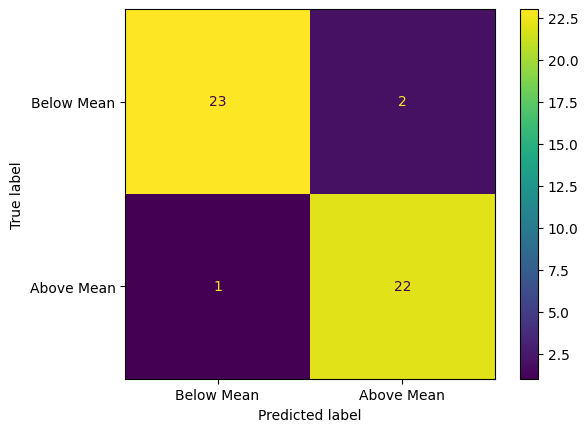

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Mean', 'Above Mean'])
    disp.plot()
    plt.show()


model, y_pred, input_size, output_size, X_train, X_test, y_train, y_test = main(ds, pipeline)

threshold = np.mean(y_test)
y_pred_cat = (y_pred > threshold).astype(int)
y_test_cat = (y_test > threshold).astype(int)

plot_confusion_matrix(y_test_cat, y_pred_cat)



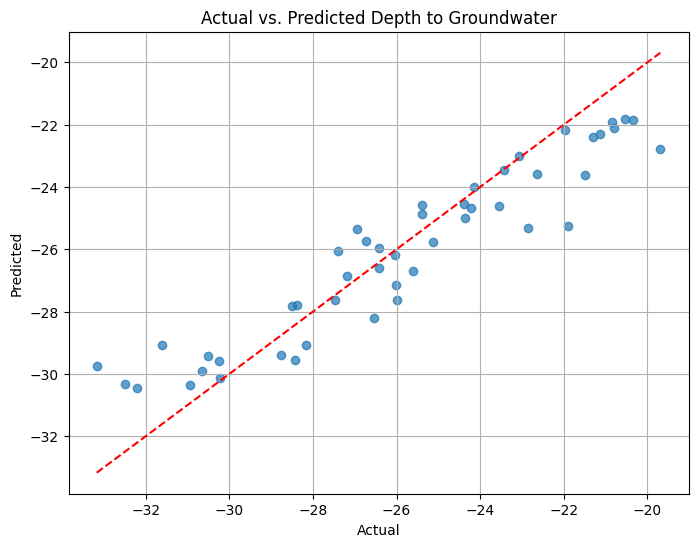

In [ ]:
# === Plot Actual vs Predicted ===
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Depth to Groundwater")
plt.grid(True)
plt.show()